# 9 Nov 23 - Activity: Applying The Fast Fourier Transform

We were able to find the complex expansion coefficients for a signal using a Fourier series. However, this method is only applicable to periodic signals. Here we will introduce the Discrete Fourier Transform (DFT) and the Fast Fourier Transform (FFT) which can be used to find the complex expansion coefficients for any signal. The DFT is the discrete analog to our expansion approach, the FFT improves the algorithmic efficiency of the DFT, which we won't describe.

Let's remind ourselves of the Fourier series expansion for a periodic signal $x(t)$ with some period $T_0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## A sinusoidal signal with a DC offset

In this example we will use a sinusoidal signal with a DC offset. The signal is defined as:

$$V(t) = A_0 \sin(2\pi f_0 t) + A_1 \sin(2\pi f_1 t) + A_2 \sin(2\pi f_2 t) + C$$

We create the signal a graph it.

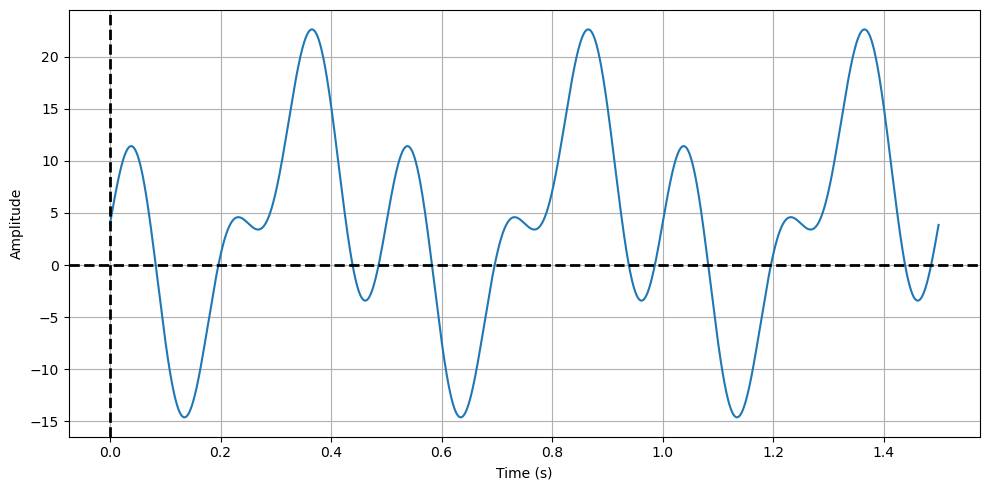

In [20]:
def summed_signal(t, A, f, C=0):
    """Creates a signal with multiple frequencies."""
    return A[0] * np.sin(2 * np.pi * f[0]*t) + A[1] * np.sin(2 * np.pi * f[1]*t) + A[2]*np.sin(2 * np.pi * f[2]*t) + C

T0 = 0.5 # Signal period
N = 1000 # Number of samples
dt = T0/N # Time step
t = np.arange(0, 3*T0, dt)  # Time points

f = np.array([1/T0, 2/T0, 3/T0]) # Frequencies
A = np.array([-10, 5, 8]) # Amplitudes
C = 4  # DC Offset

summed = summed_signal(t, A, f, C)

plt.figure(figsize=(10, 5))

plt.plot(t, summed)

plt.axvline(x=0, color='k', linestyle='--', lw=2)
plt.axhline(y=0, color='k', linestyle='--', lw=2)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.grid()
plt.tight_layout()

## Extracting the Fourier coefficients

Let's extract the Fourier coefficients. We defined the base peridicity $T_0$ in the code above. If it was not changed it was 0.5 seconds. We will use this to define the base frequency of the signal $f_0 = 1/T_0 = 1/0.5 = 2$ Hz. We have two more parts of the signal from frequencies $f_1 = 4$ Hz and $f_2 = 6$ Hz. We will use the Fourier series expansion to find the complex expansion coefficients $c_n$.

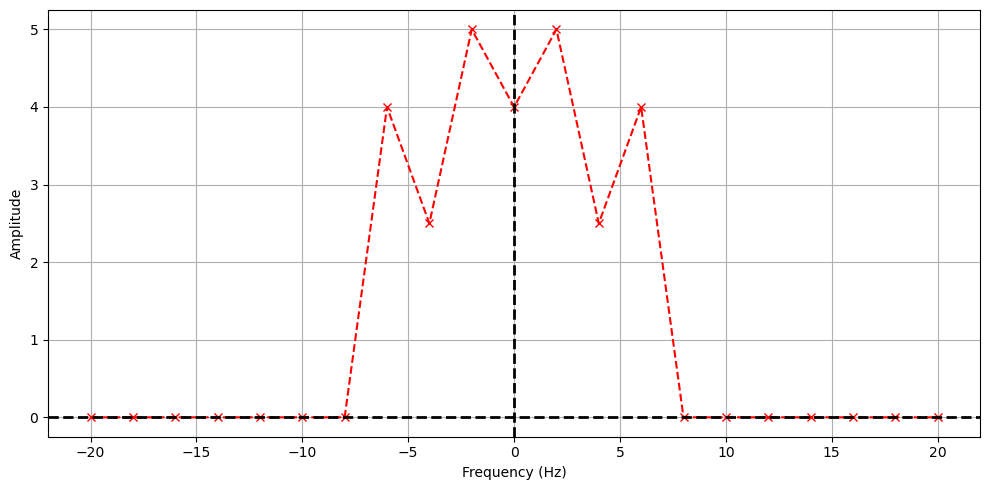

In [21]:
def compute_cn(t_, f, n):
    """Computes the Fourier coefficient c_n for a given time array.
    Assumes that the time array is evenly spaced. f is the signal 
    and must have the same length as t."""
    dt = t_[1] - t_[0]
    
    return 1/T0 * np.sum(f * np.exp(-1j * 2 * np.pi * n * t_/T0)) * dt

def compute_power_spectrum(t_, f, N):
    """Computes the power spectrum for a given time array and signal.
    Returns the coefficients from -N,N."""
    cn = np.zeros(2 * N + 1, dtype=complex)
    for n in range(-N , N + 1):
        cn[n + N] = compute_cn(t_, f, n)
    return cn

t_ = np.arange(0, T0, dt)  # Time points for a single period
N = 10 # Number of coefficients (2N+1)
freqs = np.arange(-N, N+1) / T0 # Frequencies

cn = compute_power_spectrum(t_, summed[:len(t_)], N) # Compute the coefficients

plt.figure(figsize=(10, 5))

plt.plot(freqs, np.abs(cn), '--rx')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.tight_layout()
plt.grid()

### Where are the coefficients?

We get both positive and negative frequencies. But notice that if we add the amplitudes of the matched positive and negative amplitudes, we get the value of the coefficients in our constructed signal. This is because the signal is real, so the coefficients are conjugate symmetric. We can use this to plot the coefficients in a more intuitive way. Notice the DC part of the signal is NOT conjugate symmetric, so we don't add it to the negative frequency part.

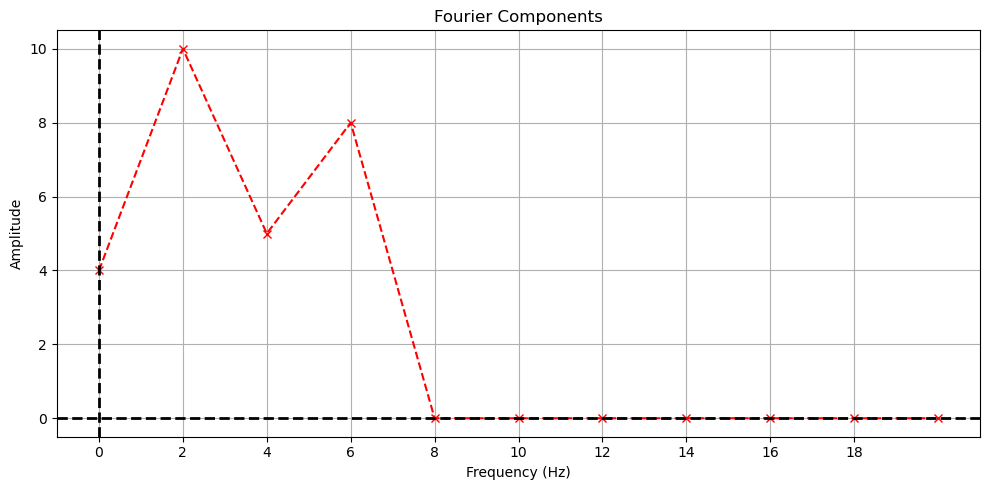

In [7]:
plt.figure(figsize=(10, 5))

x = np.insert(freqs[N+1:], 0, freqs[N])
y = np.insert(2*np.abs(cn[N+1:]), 0, np.abs(cn[N]))

plt.plot(x, y, '--rx')

plt.title('Fourier Components')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)
plt.xticks(np.arange(0,20,2))

plt.tight_layout()
plt.grid()

## The Discrete Fourier Transform

One of the issues about the decomposition we have done is that it assumes the signal is periodic. In practice, we often have signals that are not periodic. For example, consider the signal below, which is a wave packet that is not periodic. This signal is still of interest to us and can often contain useful physics. But the techniques we have used so far will not work for this signal.

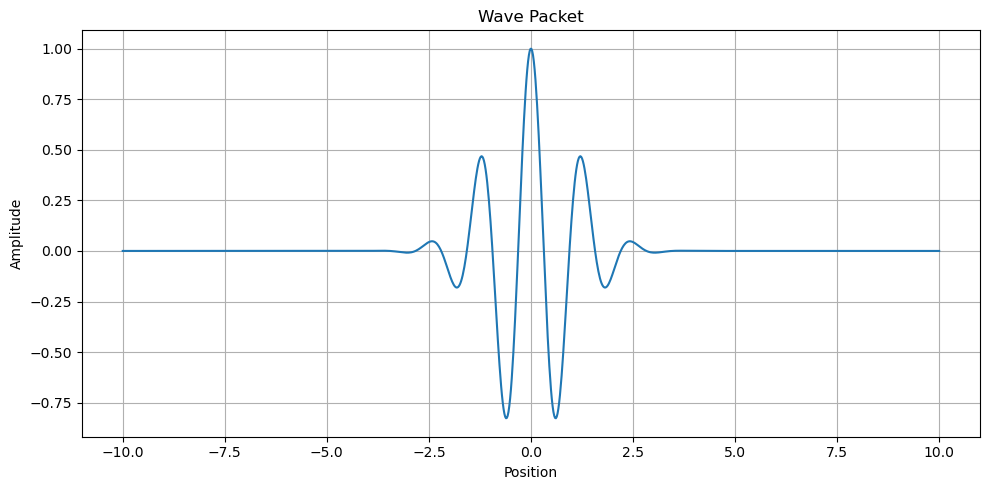

In [8]:
# Define the wave packet parameters
k0 = 5  # central wavenumber
x0 = 0  # initial position
spread = 1  # spread of the packet

# Create a space vector
x = np.linspace(-10, 10, 1000)

# Define the wave packet function
def wave_packet(x, k0, x0, spread):
    return np.exp(-0.5 * ((x - x0) / spread) ** 2) * np.cos(k0 * x)

# Calculate the wave packet
psi = wave_packet(x, k0, x0, spread)

# Plot the wave packet
plt.figure(figsize=(10, 5))
plt.plot(x, psi)
plt.title('Wave Packet')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()

### Enter the Discrete Fourier Transform

The [Discrete Fourier Transform (DFT)](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) is a way to decompose a signal into a sum of sinusoids, but it does not require the signal to be periodic. You can think of it as a discretization of the processes we developed earlier. The expansion of the signal is still as it was before, but we understand it represents a finite number of samples of the signal:

$$V(t) = \sum_{n=0}^{N-1} c_n e^{i n \omega t}.$$

However, we now understand that the signal is only defined at discrete times $t_n = n \Delta t$ where $\Delta t$ is the time between samples. We can then write the Fourier coefficients as:

$$c_n \approx \frac{1}{T_0} \sum_{k=0}^{N-1} V(t_k)e^{-i n \omega t_k} \Delta t$$

where $V(t_k)$ is the value of the signal at time $t_k$ and $T_0 = N \Delta t$ is the total time of the signal.

### Assumptions

In doing this, we are not creating a tool that will always work. We note a few important assumptions and caveats:

1. **Periodicity**: The DFT assumes that the input signal is periodic and that the period is exactly the length of the sample window. This means that the finite sequence of data points provided to the DFT is one period of a periodic signal that repeats indefinitely.

2. **Discrete Samples**: The signal being transformed is assumed to be sampled at discrete intervals. The DFT operates on these discrete samples and does not account for any data between the samples.

3. **Finite Duration**: The DFT is designed to handle signals of finite duration. The signal is assumed to have a finite number of samples, which is the number of points in the DFT.

4. **Equally-Spaced Samples**: The samples are assumed to be evenly spaced in time (or space, depending on the context of the signal). This uniform spacing is critical because non-uniformly spaced samples would require a different transform, such as the Non-uniform Discrete Fourier Transform (NDFT).

## The Fast Fourier Transform

While we can use the DFT directly, the FFT is more efficient and has become the standard way to perform these analyses. The code to have `numpy.fft` perform the FFT is pretty simple. But there's many things to understand about the FFT and a variety of ways to produce spurious and incoherent results. Let's use the simple signal we have above to make go through an analysis.

### The FFT in `numpy.fft`

We start by importing the libraries. Then we need to:

1. Define the time array
2. Define the signal
3. Perform the FFT using `numpy.fft.fft` (*We imported `numpy.fft` below, so you can call ``fft`` directly.*)
4. Plot the coefficients
5. Plot the power spectrum

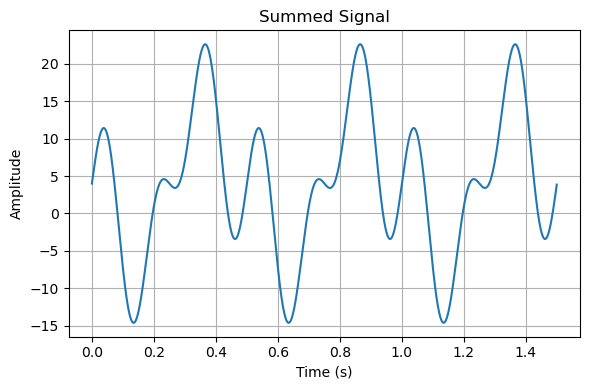

In [9]:
from numpy.fft import fft, fftfreq

plt.figure(figsize=(6, 4))
plt.plot(t, summed)

plt.title('Summed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.grid()

### Computing and plotting Fourier Coefficients

We now use `fft` to calculate the Fourier transform of the signal and `fftfreq` to calculate the frequencies associated with the transform. This is a standard way to do this analysis, but the most common mistakes involve the frequencies. Because it is a real signal, we don't worry about the negative frequencies, they are duplicate information. The amplitudes of the non DC frequencies are doubled like before to illustrate the Fourier coefficients.

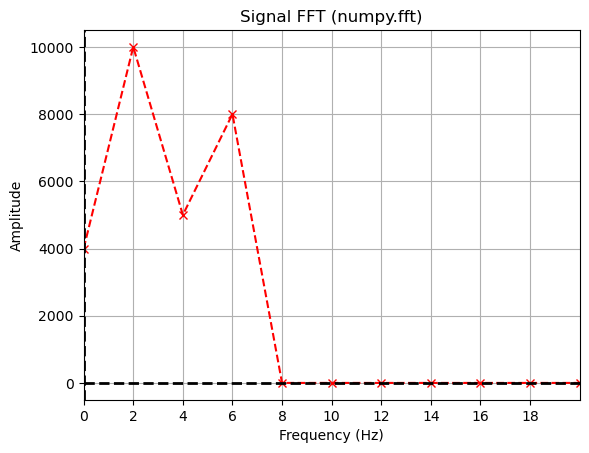

In [10]:
t_ = np.arange(0, T0, dt)  # Time points for a single period
one_cycle = summed[:len(t_)] # One cycle of the summed signal
N = int(T0/dt/2) # Maximum number of coefficients

fft_summed = fft(one_cycle)
freqs_array = fftfreq(len(one_cycle), dt)

x = freqs_array[:N]
y = np.insert(2*np.abs(fft_summed[1:N]), 0, np.abs(fft_summed[0]))

plt.plot(x, y, '--rx')

plt.title('Signal FFT (numpy.fft)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.xlim(0, 20)
plt.xticks(np.arange(0,20,2))

plt.grid()

Notice the FFT looks precisely the same as before. But the Amplitudes are scaled differently. The total amplitude is not the same, but the relative values are still meaningful. If the maximum amplitude is scaled to the amplitude we had before, then the signal would look the same. However, it's typical to instead plot these scaled in some way. The most common way is to either scale them by the maximum amplitude or the sum of all the amplitudes. Each have their own purpose and meaning. Below we plot them both for comparison.

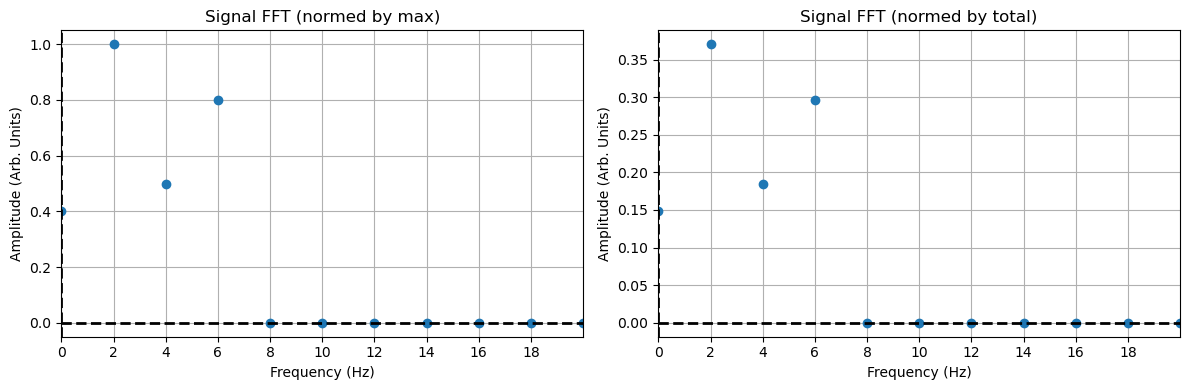

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(x, y/np.max(y), 'o')
plt.xlim(0,20)
plt.xticks(np.arange(0,20,2))

plt.title('Signal FFT (normed by max)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Arb. Units)')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.grid()

plt.subplot(122)
plt.plot(x, np.abs(y)/np.sum(y), 'o')
plt.xlim(0,20)
plt.xticks(np.arange(0,20,2))

plt.title('Signal FFT (normed by total)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Arb. Units)')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.tight_layout()
plt.grid()

### Investigating the FFT

Now that you have developed some code and some conceptual understanding of the FFT process, let's investigate some of the more nuanced aspects.

**&#9989; Do this**

1. Complete the power spectrum analysis for the following signals that you construct:
    * Your signals have two frequencies that are close together (competing frequencies)
    * Your signal has frequencies that are not integer multiples of the sampling rate (aliasing)
2. Use `fft` to do these analyses and plot the spectra.
3. For the first case, what seems to be needed to resolve the two frequencies?
4. For the second case, what happens when the frequency is not an integer multiple of the sampling rate? What does this mean when signals have two frequencies that are not integer multiples of each other or the sampling rate?

## COMPTETING FREQUENCIES

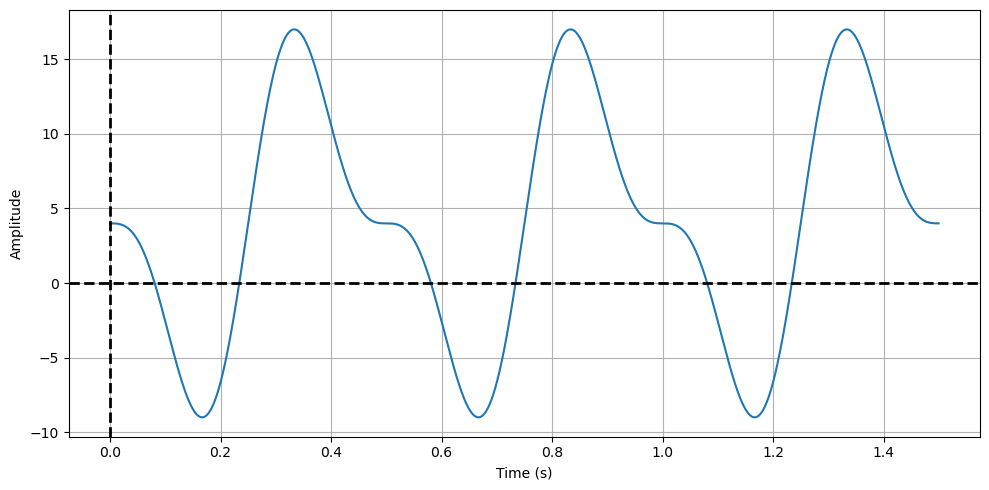

In [23]:
def summed_signal(t, A, f, C=0):
    """Creates a signal with multiple frequencies."""
    return A[0] * np.sin(2 * np.pi * f[0]*t) + A[1] * np.sin(2 * np.pi * f[1]*t) + C

T0 = 0.5 # Signal period
N = 1000 # Number of samples
dt = T0/N # Time step
t = np.arange(0, 3*T0, dt)  # Time points

f = np.array([1/T0, 2/T0]) # Frequencies
A = np.array([-10, 5]) # Amplitudes
C = 4  # DC Offset

summed = summed_signal(t, A, f, C)

plt.figure(figsize=(10, 5))

plt.plot(t, summed)

plt.axvline(x=0, color='k', linestyle='--', lw=2)
plt.axhline(y=0, color='k', linestyle='--', lw=2)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.grid()
plt.tight_layout()

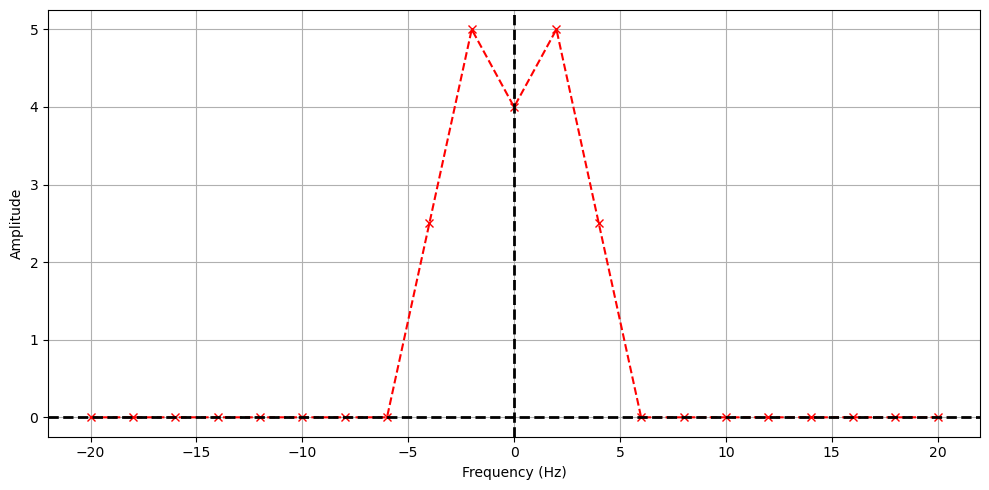

In [24]:
def compute_cn(t_, f, n):
    """Computes the Fourier coefficient c_n for a given time array.
    Assumes that the time array is evenly spaced. f is the signal 
    and must have the same length as t."""
    dt = t_[1] - t_[0]
    
    return 1/T0 * np.sum(f * np.exp(-1j * 2 * np.pi * n * t_/T0)) * dt

def compute_power_spectrum(t_, f, N):
    """Computes the power spectrum for a given time array and signal.
    Returns the coefficients from -N,N."""
    cn = np.zeros(2 * N + 1, dtype=complex)
    for n in range(-N , N + 1):
        cn[n + N] = compute_cn(t_, f, n)
    return cn

t_ = np.arange(0, T0, dt)  # Time points for a single period
N = 10 # Number of coefficients (2N+1)
freqs = np.arange(-N, N+1) / T0 # Frequencies

cn = compute_power_spectrum(t_, summed[:len(t_)], N) # Compute the coefficients

plt.figure(figsize=(10, 5))

plt.plot(freqs, np.abs(cn), '--rx')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.tight_layout()
plt.grid()

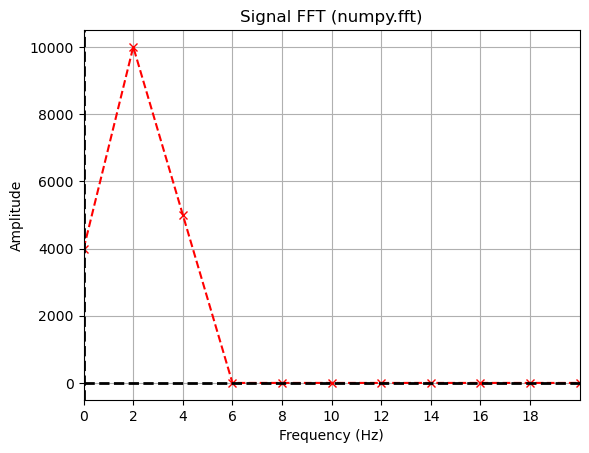

In [28]:
t_ = np.arange(0, T0, dt)  # Time points for a single period
one_cycle = summed[:len(t_)] # One cycle of the summed signal
N = int(T0/dt/2) # Maximum number of coefficients

fft_summed = fft(one_cycle)
freqs_array = fftfreq(len(one_cycle), dt)

x = freqs_array[:N]
y = np.insert(2*np.abs(fft_summed[1:N]), 0, np.abs(fft_summed[0]))

plt.plot(x, y, '--rx')

plt.title('Signal FFT (numpy.fft)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.xlim(0, 20)
plt.xticks(np.arange(0,20,2))

plt.grid()

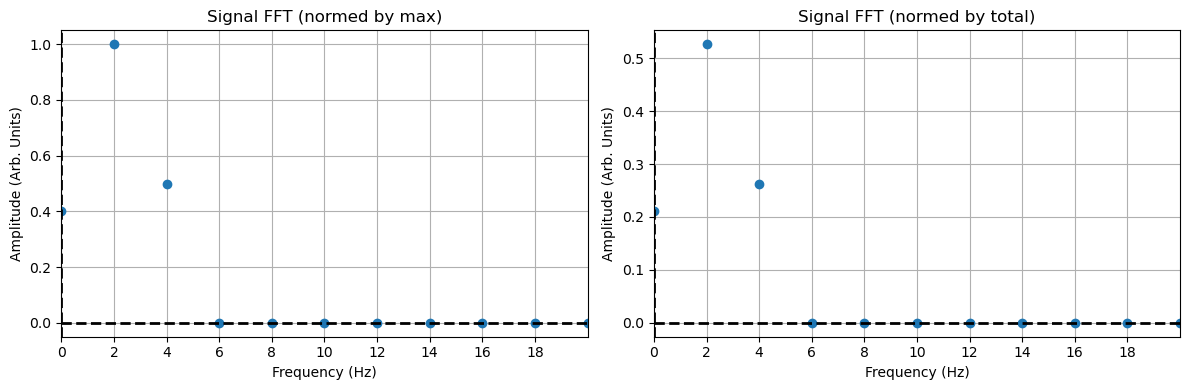

In [30]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(x, y/np.max(y), 'o')
plt.xlim(0,20)
plt.xticks(np.arange(0,20,2))

plt.title('Signal FFT (normed by max)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Arb. Units)')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.grid()

plt.subplot(122)
plt.plot(x, np.abs(y)/np.sum(y), 'o')
plt.xlim(0,20)
plt.xticks(np.arange(0,20,2))

plt.title('Signal FFT (normed by total)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Arb. Units)')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.tight_layout()
plt.grid()

## ALIASING FREQUENCIES

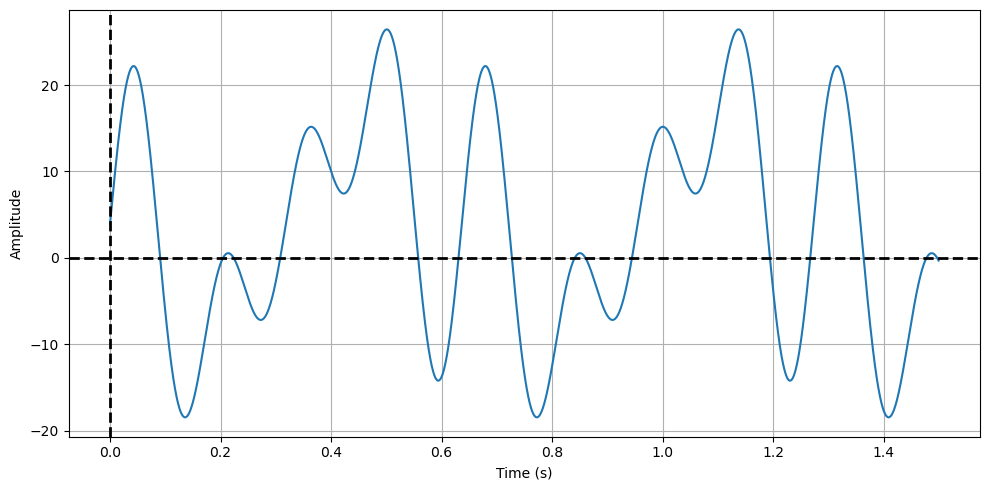

In [32]:
def summed_signal(t, A, f, C=0):
    """Creates a signal with multiple frequencies."""
    return A[0] * np.sin(2 * np.pi * f[0]*t) + A[1] * np.sin(2 * np.pi * f[1]*t) + A[2]*np.sin(2 * np.pi * f[2]*t) + A[3]*np.sin(2 * np.pi * f[3]*t) + C

T0 = 0.5 # Signal period
N = 1000 # Number of samples
dt = T0/N # Time step
t = np.arange(0, 3*T0, dt)  # Time points

f = np.array([np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]) # Frequencies
A = np.array([-10, 5, 8, 11]) # Amplitudes
C = 4  # DC Offset

summed = summed_signal(t, A, f, C)

plt.figure(figsize=(10, 5))

plt.plot(t, summed)

plt.axvline(x=0, color='k', linestyle='--', lw=2)
plt.axhline(y=0, color='k', linestyle='--', lw=2)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.grid()
plt.tight_layout()

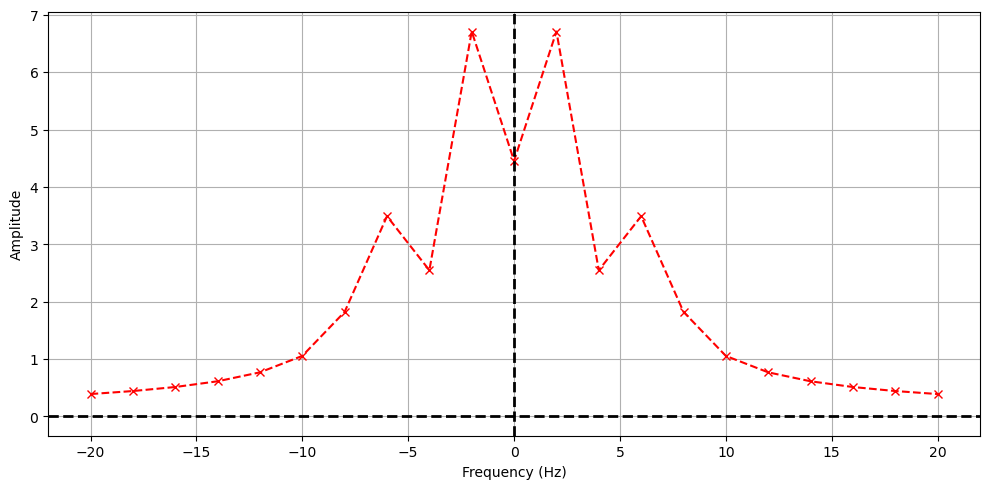

In [33]:
def compute_cn(t_, f, n):
    """Computes the Fourier coefficient c_n for a given time array.
    Assumes that the time array is evenly spaced. f is the signal 
    and must have the same length as t."""
    dt = t_[1] - t_[0]
    
    return 1/T0 * np.sum(f * np.exp(-1j * 2 * np.pi * n * t_/T0)) * dt

def compute_power_spectrum(t_, f, N):
    """Computes the power spectrum for a given time array and signal.
    Returns the coefficients from -N,N."""
    cn = np.zeros(2 * N + 1, dtype=complex)
    for n in range(-N , N + 1):
        cn[n + N] = compute_cn(t_, f, n)
    return cn

t_ = np.arange(0, T0, dt)  # Time points for a single period
N = 10 # Number of coefficients (2N+1)
freqs = np.arange(-N, N+1) / T0 # Frequencies

cn = compute_power_spectrum(t_, summed[:len(t_)], N) # Compute the coefficients

plt.figure(figsize=(10, 5))

plt.plot(freqs, np.abs(cn), '--rx')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.tight_layout()
plt.grid()

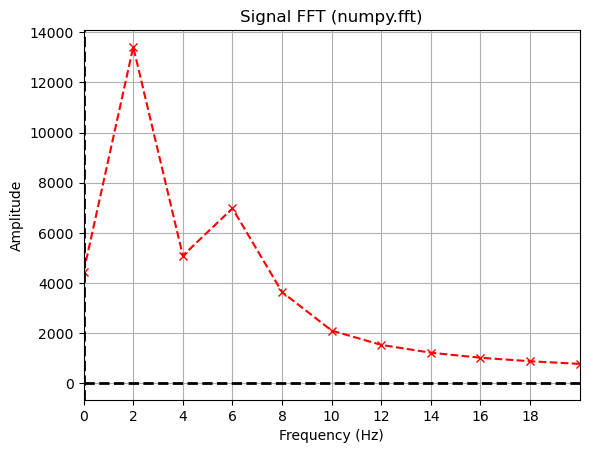

In [34]:
t_ = np.arange(0, T0, dt)  # Time points for a single period
one_cycle = summed[:len(t_)] # One cycle of the summed signal
N = int(T0/dt/2) # Maximum number of coefficients

fft_summed = fft(one_cycle)
freqs_array = fftfreq(len(one_cycle), dt)

x = freqs_array[:N]
y = np.insert(2*np.abs(fft_summed[1:N]), 0, np.abs(fft_summed[0]))

plt.plot(x, y, '--rx')

plt.title('Signal FFT (numpy.fft)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.xlim(0, 20)
plt.xticks(np.arange(0,20,2))

plt.grid()

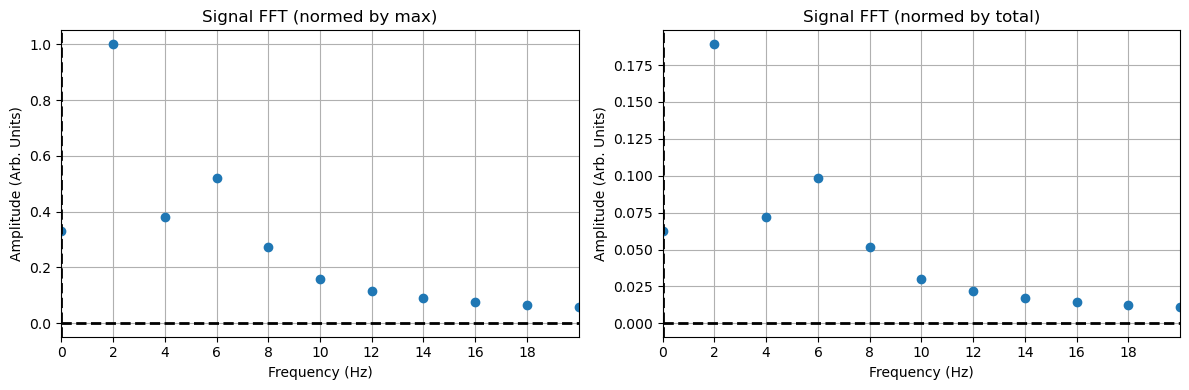

In [35]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(x, y/np.max(y), 'o')
plt.xlim(0,20)
plt.xticks(np.arange(0,20,2))

plt.title('Signal FFT (normed by max)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Arb. Units)')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.grid()

plt.subplot(122)
plt.plot(x, np.abs(y)/np.sum(y), 'o')
plt.xlim(0,20)
plt.xticks(np.arange(0,20,2))

plt.title('Signal FFT (normed by total)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Arb. Units)')

plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.axvline(x=0, color='k', linestyle='--', lw=2)

plt.tight_layout()
plt.grid()

**Competing Frequencies**: When you have two frequencies that are very close together, the FFT may have difficulty resolving them, and you may observe spectral leakage where the frequencies appear spread out in the power spectrum. To better resolve such frequencies, you would need a higher sampling rate or a longer signal duration.

**Non-Integer Multiple of Sampling Rate (Aliasing)**: When the frequency of a signal is not an integer multiple of the sampling rate, you can experience aliasing, where the signal appears at a different frequency in the FFT. In the power spectrum, the signal's power may be observed at a frequency that is an integer multiple of the sampling rate (the aliased frequency). This phenomenon is called aliasing and can lead to incorrect frequency estimation.